In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, GRU, Dropout, Bidirectional, Conv1D, Concatenate
from tensorflow.keras.layers import SpatialDropout1D,GlobalAveragePooling1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
from keras.optimizers import Adam



2024-05-18 12:40:54.743944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 12:40:54.744040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 12:40:54.862171: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/fake-news/FakeNewsNet.csv')

In [3]:
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [4]:
df[['tweet_num','real']].corr() 
# Not a huge correlation between number of retweets and reality of the news. Approach as a NLP task 

,tweet_num,real
tweet_num,1.000000,-0.051411
real,-0.051411,1.000000


In [5]:
X=df[['title']]
y=df[['real']]

In [6]:
X,y

(                                                   title
 0      Kandi Burruss Explodes Over Rape Accusation on...
 1      People's Choice Awards 2018: The best red carp...
 2      Sophia Bush Sends Sweet Birthday Message to 'O...
 3      Colombian singer Maluma sparks rumours of inap...
 4      Gossip Girl 10 Years Later: How Upper East Sid...
 ...                                                  ...
 23191  Pippa Middleton wedding: In case you missed it...
 23192  Zayn Malik & Gigi Hadid’s Shocking Split: Why ...
 23193  Jessica Chastain Recalls the Moment Her Mother...
 23194  Tristan Thompson Feels "Dumped" After Khloé Ka...
 23195  Kelly Clarkson Performs a Medley of Kendrick L...
 
 [23196 rows x 1 columns],
        real
 0         1
 1         1
 2         1
 3         1
 4         1
 ...     ...
 23191     1
 23192     0
 23193     1
 23194     0
 23195     1
 
 [23196 rows x 1 columns])

## Text Preprocessing

In [7]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

In [8]:
# Initialize a set of stopwords. Searching a set is faster than searching lists/arrays.
stops = set(stopwords.words("english"))

In [9]:
# initialize Tokenizer to encode strings into integers and stemmer
tokenizer = Tokenizer()
stemmer = SnowballStemmer(language='english') 

In [10]:
# Look at the titles before preprocessing.
X['title'].values

array(["Kandi Burruss Explodes Over Rape Accusation on 'Real Housewives of Atlanta' Reunion (Video)",
       "People's Choice Awards 2018: The best red carpet looks",
       "Sophia Bush Sends Sweet Birthday Message to 'One Tree Hill' Co-Star Hilarie Burton: 'Breyton 4eva'",
       ...,
       "Jessica Chastain Recalls the Moment Her Mother's Boyfriend Slapped Her: 'I Just Kicked Him in the Genitals'",
       'Tristan Thompson Feels "Dumped" After Khloé Kardashian Refuses To Let Him Move Into LA Home (EXCLUSIVE)',
       "Kelly Clarkson Performs a Medley of Kendrick Lamar's 'Humble' & More Hits at the Billboard Music Awards"],
      dtype=object)

In [11]:
def remove_stops_stem(_str):
    """Function to remove stopwords and stem the words in an inputed string (_str).
    Splits the lower case _str, removes punctuation from each word (w), and if that
    word is not a stopword appends the stemmed word."""
    out = []
    for w in _str.lower().split():
        w = re.sub("[^a-zA-Z]"," ", w)
        if w not in stops:
            out.append(stemmer.stem(w))
                
    return " ".join(out)

In [12]:
#Check a title before processing
_str = X['title'].values[0]
_str

"Kandi Burruss Explodes Over Rape Accusation on 'Real Housewives of Atlanta' Reunion (Video)"

In [13]:
#Check same title after processing. 
remove_stops_stem( _str)

'kandi burruss explod rape accus  real housew atlanta  reunion  video '

In [14]:
# Stemmers aren't perfect, snowball stemmer seems to have solid performance overall. 

In [15]:
#Apply preprocessing function to all the titles and save in the training data. Takes some time.
X['title']=X['title'].apply(remove_stops_stem)

In [16]:
# Max number of words in a title
max_len = max([len(x.split()) for x in X['title'].values])

In [17]:
print(max_len)

35


In [18]:
# create vocabulary from all words in our dataset for encoding
tokenizer.fit_on_texts(X['title'].values)

In [19]:
# count number of unique words. This is passed into the embedding layer,
# which needs to be at least this size
vocabulary_size = len(tokenizer.word_index) + 1
print("Vocab size for tokenizer is: {0}".format(vocabulary_size))

Vocab size for tokenizer is: 15075


In [20]:
#Train/test split.
X_train, X_test, y_train, y_test = train_test_split(X['title'].values, y['real'].values, test_size=0.2)

In [21]:
# convert phrases to sequences of integers
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [22]:
# ensure every row has same size by padding with zeros
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_len, padding='post')

## Deep GRU Neural Network:  

In [23]:
# Looking ahead to utilizing a pretrained network on the 300 dim fasttext pretrained 
# embeddings, set the embed_dim to be 300
embed_dim = 300

In [24]:
def assemble_model_noConv(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel1=3, dense_units=128, dr=0.1):

    model = Sequential()
    model.add(Embedding(vocabulary_size, embed_dim, input_length=max_len))
    model.add(SpatialDropout1D(spatial_dr))
    model.add(Bidirectional(GRU(units)))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dr))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = lr, weight_decay = lr_d), metrics=['accuracy'])
    
    file_path = "best_model.keras"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

    history = model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), 
                    batch_size=128, callbacks=[early_stop,check_point])
    #model.summary()    
    return model

In [25]:
model_none = assemble_model_noConv(lr=1e-3, lr_d=1e-8, units = 128, spatial_dr = 0.3, kernel1=3, dense_units=128, dr=0.3)

Epoch 1/10
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7595 - loss: 0.5099
Epoch 1: val_loss improved from inf to 0.37714, saving model to best_model.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7605 - loss: 0.5084 - val_accuracy: 0.8373 - val_loss: 0.3771
Epoch 2/10
142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8793 - loss: 0.2927
Epoch 2: val_loss improved from 0.37714 to 0.37474, saving model to best_model.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8792 - loss: 0.2928 - val_accuracy: 0.8356 - val_loss: 0.3747
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9174 - loss: 0.2121
Epoch 3: val_loss did not improve from 0.37474
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9174 - loss: 0.2122 - val_accuracy: 0.8222 - val_loss: 0.4207
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9370 - loss: 0.1626
Epoch 4: val_loss did not improve from 0.37474
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/s

In [26]:
def assemble_model_Conv(units=0, spatial_dr=0.0, kernel1=3, dense_units=128, dr=0.1, conv_size=32):

    model = Sequential()
    model.add(Embedding(vocabulary_size, embed_dim, input_length=max_len))
    model.add(SpatialDropout1D(spatial_dr))
    model.add(Bidirectional(GRU(units,return_sequences=True)))
    model.add(Conv1D(conv_size, kernel_size = kernel1, padding='valid', kernel_initializer='he_uniform'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dr))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    file_path = "best_model.keras"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    history = model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), 
                    batch_size=128, callbacks=[early_stop,check_point])
    #model.summary()
    return model

In [27]:
model_conv = assemble_model_Conv( units=128, spatial_dr=0.5, kernel1=3, 
                                   dense_units=128, dr=0.5, conv_size=32)

Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7639 - loss: 0.5353
Epoch 1: val_loss improved from inf to 0.37811, saving model to best_model.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.7641 - loss: 0.5349 - val_accuracy: 0.8392 - val_loss: 0.3781
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8690 - loss: 0.3160
Epoch 2: val_loss improved from 0.37811 to 0.37192, saving model to best_model.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8690 - loss: 0.3161 - val_accuracy: 0.8397 - val_loss: 0.3719
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9069 - loss: 0.2418
Epoch 3: val_loss did not improve from 0.37192
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9069 - loss: 0.2418 - val_accuracy: 0.8319 - val_loss: 0.4116
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9334 - loss: 0.1773
Epoch 4: val_loss did not improve from 0.37192
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/s

### Performance with/without convolution layer is similar, with the convolution layer the model is possibly overfitting a bit more.

## Pretrained Network

Now I will take the best architecture from the above analysis and add pretrained weights to the embedding layer. These weights will come from the fasttext pretrained word vectors.

In [28]:
fasttext_path = "/kaggle/input/fasttext-crawl-300d-2m/crawl-300d-2M.vec"

In [29]:
max_features= 20000 # Needs to be at least as large as the vocabulary size. 

In [30]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

# The rest of the code below prepares an embedding matrix to use in a Keras Embedding layer. 
# The entry at index i is the pre-trained vector for the word of 
# index i in our vectorizer's vocabulary. 
# This code takes a while to execute
#
# Reference: https://keras.io/examples/nlp/pretrained_word_embeddings/
embed_hash = dict(get_coefs(*o.strip().split(" ")) for o in open(fasttext_path))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, embed_dim))
for word, i in word_index.items():
    if i >= max_features: 
        continue
    embedding_vector = embed_hash.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [31]:
def assemble_model_pre(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, dense_units=128, dr=0.1,kernel1=3, conv_size=32):
    """ TODO
    """
    file_path = "best_model.keras"
    #check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
    #                              save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    
    x = Embedding(vocabulary_size, embed_dim, input_length=max_len, trainable=False)
    inp = Input(shape = (max_len,))
    x.build((max_len,))
    x.set_weights([embedding_matrix])
    embedded_sequences=x(inp)
    x1 = SpatialDropout1D(spatial_dr)(embedded_sequences)
    
    x_gru = Bidirectional(GRU(units ))(x1)
    #x_lstm = Bidirectional(LSTM(units, return_sequences=True))(x1)
    
    #x_conv1 = Conv1D(conv_size, kernel_size=kernel1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    #max_pool_gru = GlobalMaxPooling1D()(x_conv1)
    x1 = Dropout(dr)(Dense(dense_units, activation='relu') (x_gru))
    
    #x_conv2 = Conv1D(conv_size, kernel_size=kernel1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    #avg_pool_lstm = GlobalMaxPooling1D()(x_conv2)
    #x2 = Dropout(dr)(Dense(dense_units, activation='relu') (avg_pool_lstm))
    
    #x = Concatenate()([x1,x2])
    
    x = BatchNormalization()(x1)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    #model.summary()
    model.compile(loss = "binary_crossentropy", optimizer = Adam(learning_rate = lr, weight_decay = lr_d), metrics = ["accuracy"])
    history = model.fit(X_train_pad, y_train, epochs=40, verbose = 1, validation_data=(X_test_pad, y_test), batch_size=128, callbacks=[check_point,early_stop])
    #model = keras.saving.load_model(file_path)
    return model

In [32]:
pretrained = assemble_model_pre(lr=1e-3, lr_d=1e-8, units=128, spatial_dr=0.5, dense_units=128, dr=0.5, kernel1=3, conv_size=32)
#(lr=1e-3, lr_d=1e-8, units=128, spatial_dr=0.5, dense_units=128, dr=0.5)

Epoch 1/40
141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6190 - loss: 0.7206
Epoch 1: val_loss improved from inf to 0.51393, saving model to best_model.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6218 - loss: 0.7170 - val_accuracy: 0.7791 - val_loss: 0.5139
Epoch 2/40
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7687 - loss: 0.5145
Epoch 2: val_loss did not improve from 0.51393
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7688 - loss: 0.5143 - val_accuracy: 0.7601 - val_loss: 0.5239
Epoch 3/40
141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7821 - loss: 0.4848
Epoch 3: val_loss improved from 0.51393 to 0.43033, saving model to best_model.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7822 - loss: 0.4847 - val_accuracy: 0.8060 - val_loss: 0.4303
Epoch 4/40
141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7921 - loss: 0.4628
Epoch 4: val_loss improved from 0.43033 to 0.41910, saving model to best_model.keras


## Results Visualization

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns

In [34]:
def print_performance(clf, X, y, model_name=''):
    y_pred = np.round(clf.predict(X)).astype(int)
    
    accuracy = accuracy_score(y_pred, y)
    print("Accuracy: ", accuracy)
    print("Precision:", precision_score(y_pred, y, average='weighted'))
    print("Recall:   ", recall_score(y_pred, y, average='weighted'))
    print("F1 Score: ", f1_score(y_pred, y, average='weighted'))
    
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(9,9)) 
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

    all_sample_title = 'Model: {1} \n Accuracy Score: {0}'.format(accuracy,model_name)
    
    plt.title(all_sample_title, size = 15);

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy:  0.8122844827586206
Precision: 0.8118131763417121
Recall:    0.8122844827586206
F1 Score:  0.8120453806787188


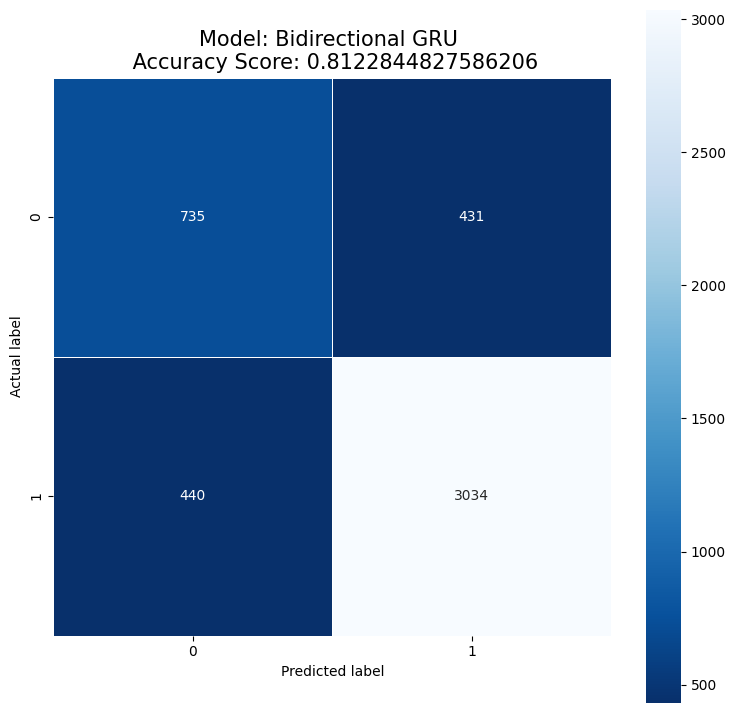

In [35]:
print_performance(model_none, X_test_pad, y_test, model_name='Bidirectional GRU')

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy:  0.83125
Precision: 0.835285580780925
Recall:    0.83125
F1 Score:  0.8330460596968144


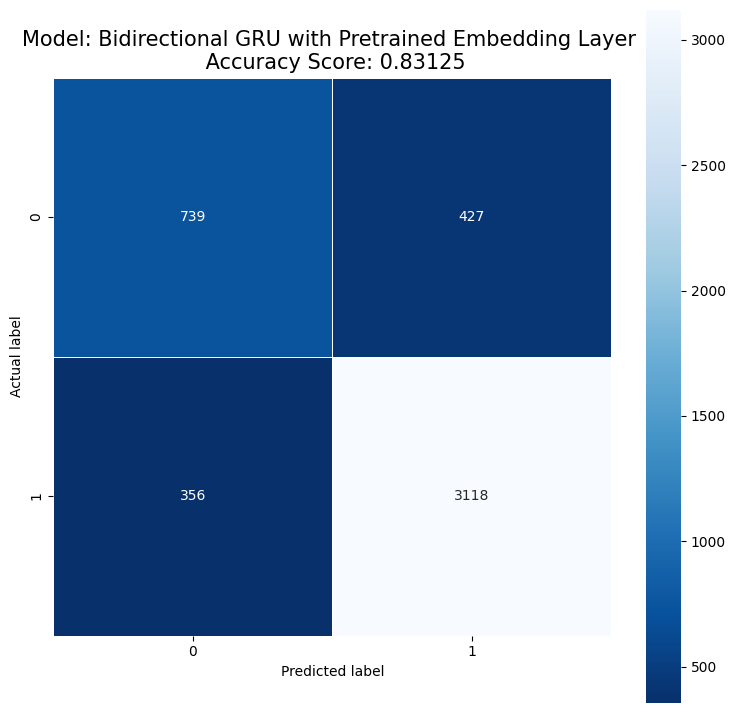

In [36]:
print_performance(pretrained, X_test_pad, y_test,model_name='Bidirectional GRU with Pretrained Embedding Layer')

The pretrained network does perform better, but its only by a little. The confusion matrices illustrate that the performance on the "0" class, which has fewer samples, was similar for both models whilst the pretrained network performs better on the "1" class. 

In [51]:
def print_performance_multi(clf, X, y, nmodels, model_name=''):
    y_pred=np.round(clf[0].predict(X)).astype(int) / nmodels
    for i in range(1,len(clf)-1):
        y_pred += np.round(clf[i].predict(X)).astype(int) / nmodels
    y_pred = np.round(y_pred).astype(int)
    accuracy = accuracy_score(y_pred, y)
    print("Accuracy: ", accuracy)
    print("Precision:", precision_score(y_pred, y, average='weighted'))
    print("Recall:   ", recall_score(y_pred, y, average='weighted'))
    print("F1 Score: ", f1_score(y_pred, y, average='weighted'))
    
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(9,9)) 
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

    all_sample_title = 'Model: {1} \n Accuracy Score: {0}'.format(accuracy,model_name)
    
    plt.title(all_sample_title, size = 15);

In [55]:
models = []

In [56]:
pretrained1 = assemble_model_pre(lr=1e-3, lr_d=1e-8, units=128, spatial_dr=0.5, dense_units=128, dr=0.5, kernel1=3, conv_size=32)
models.append(pretrained1)
pretrained2 = assemble_model_pre(lr=1e-3, lr_d=1e-8, units=128, spatial_dr=0.5, dense_units=128, dr=0.5, kernel1=3, conv_size=32)
models.append(pretrained2)
pretrained3 = assemble_model_pre(lr=1e-3, lr_d=1e-8, units=128, spatial_dr=0.5, dense_units=128, dr=0.5, kernel1=3, conv_size=32)
models.append(pretrained3)
pretrained4 = assemble_model_pre(lr=1e-3, lr_d=1e-8, units=128, spatial_dr=0.5, dense_units=128, dr=0.5, kernel1=3, conv_size=32)
models.append(pretrained4)
pretrained5 = assemble_model_pre(lr=1e-3, lr_d=1e-8, units=128, spatial_dr=0.5, dense_units=128, dr=0.5, kernel1=3, conv_size=32)
models.append(pretrained5)

Epoch 1/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6752 - loss: 0.6483
Epoch 1: val_loss improved from inf to 0.51702, saving model to best_model.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6755 - loss: 0.6479 - val_accuracy: 0.7976 - val_loss: 0.5170
Epoch 2/40
141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7681 - loss: 0.5077
Epoch 2: val_loss improved from 0.51702 to 0.46266, saving model to best_model.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7682 - loss: 0.5075 - val_accuracy: 0.8030 - val_loss: 0.4627
Epoch 3/40
141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7856 - loss: 0.4810
Epoch 3: val_loss did not improve from 0.46266
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7856 - loss: 0.4810 - val_accuracy: 0.7787 - val_loss: 0.4936
Epoch 4/40
141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7894 - loss: 0.4664
Epoch 4: val_loss improved from 0.46266 to 0.42413, saving model to best_model.keras


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy:  0.8364224137931034
Precision: 0.8396015913183023
Recall:    0.8364224137931034
F1 Score:  0.8378567220934732


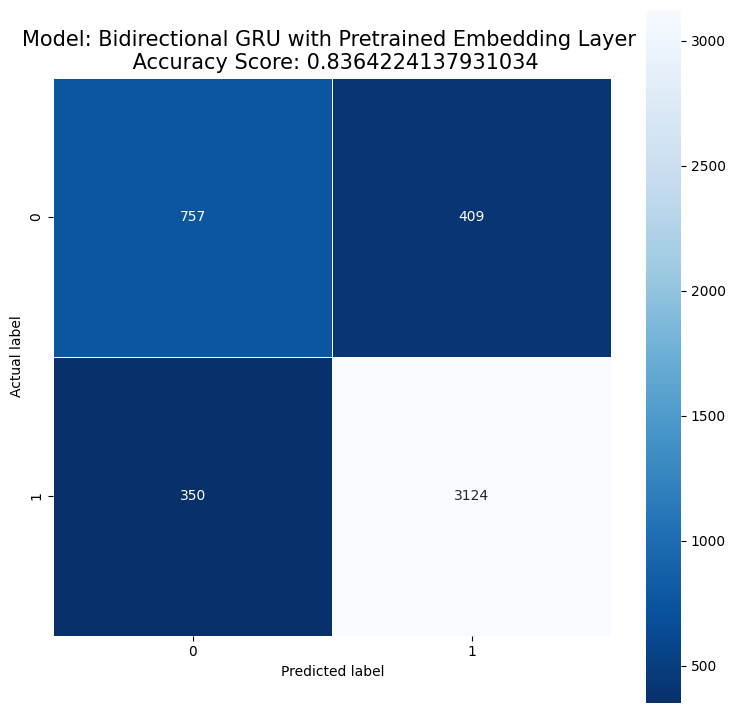

In [57]:
print_performance_multi(models, X_test_pad, y_test,5,model_name='Bidirectional GRU with Pretrained Embedding Layer')

Adding models together boosts performance a little. The confusion matrix shows that there is a slight improvement in classifying 1's, and a more substantial improvement classifying 0's. 

## Sources

* https://colab.research.google.com/drive/1AnRzfi6rm4aqpUdf7jbi6usrSsuhnEyW?usp=sharing#scrollTo=BeaWC0FLWB0Q

* https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw